In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

run1=pd.read_csv('angle_log_trotForwardrun2.csv')

from inversegait import preprocessing
processangles_radians= preprocessing.RawJointAngleProcessed(run1) #angles preprocessed to radians

from inversegait import frequencyanal
gaitF=np.mean(frequencyanal.gaitfrequency(run1,'trot 1')) # getting the gair frequency in Hz
print(gaitF)

from inversegait import foot_positions
footpos_mm,time=foot_positions.LegSeparationFootPositions(run1)

from inversegait import stanceDC
stancedutycycles,pp,_,_,_=stanceDC.duty_cycle_compute(run1) # getting the duty cycles for the data

from inversegait import StrideLength
strideL=StrideLength.stridelength(footpos_mm)

from inversegait import swingheight
swingH,_=swingheight.clearanceheight(footpos_mm,time,pp)
print(swingH)

from inversegait import PD
phased_legs=PD.phasedifference(footpos_mm,time,run1)
print(phased_legs)


Front Right CCW is -ve for you
Rear Right CCW is -ve for you
2.3000000000000003
Front Right CCW is -ve for you
Rear Right CCW is -ve for you
Front Right CCW is -ve for you
Rear Right CCW is -ve for you
4.6825236647998025
(4, 236)
[array([0.48631356]), array([0.]), array([0.]), array([0.48631356])]


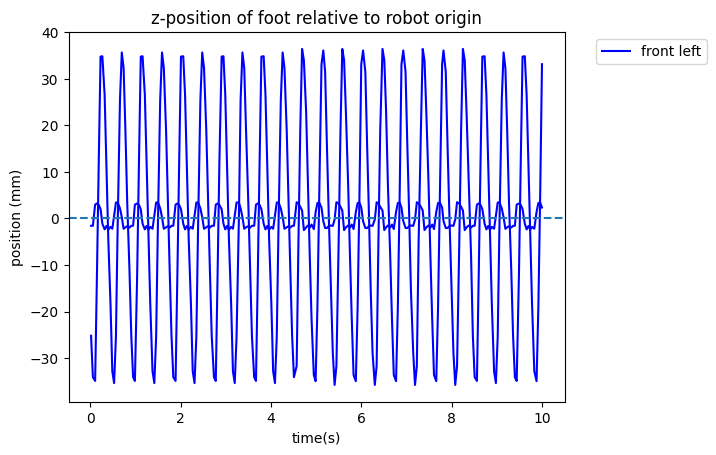

In [160]:
# plotting the foot positions:
# plt.plot(time,footpos_mm[0,:,0]-np.mean(footpos_mm[0,:,0]),label='Front Right',color='k')
plt.plot(time,footpos_mm[1,:,0]-np.mean(footpos_mm[1,:,0]), label='front left',color='b')
# plt.plot(time,footpos_mm[2,:,0], label='rear right',color='r')
# plt.plot(time,footpos_mm[3,:,0],label='rear left',color='g')
plt.legend(bbox_to_anchor=(1.05,1))
plt.title('x-position of foot relative to robot origin')
plt.ylabel('position (mm)')
plt.xlabel('time(s)')
# plt.show()

## z positions need to filtered using lowpass
# plt.plot(time,footpos_mm[0,:,2]-np.mean(footpos_mm[0,:,2]),label='Front Right',color='k')
plt.plot(time,footpos_mm[1,:,2]-np.mean(footpos_mm[1,:,2]), label='front left',color='b')
# plt.plot(time,footpos_mm[2,:,2], label='rear right',color='r')
# plt.plot(time,footpos_mm[3,:,2],label='rear left',color='g')
# plt.legend(bbox_to_anchor=(1.05,1))
plt.title('z-position of foot relative to robot origin')
plt.axhline(y=0, linestyle='--')
plt.ylabel('position (mm)')
plt.xlabel('time(s)')
plt.show()


In [161]:
from inversegait import JointOffsets
pp=JointOffsets
xoff=pp['Front Left']['x_offset']
zoff=pp['Front Left']['z_offset']



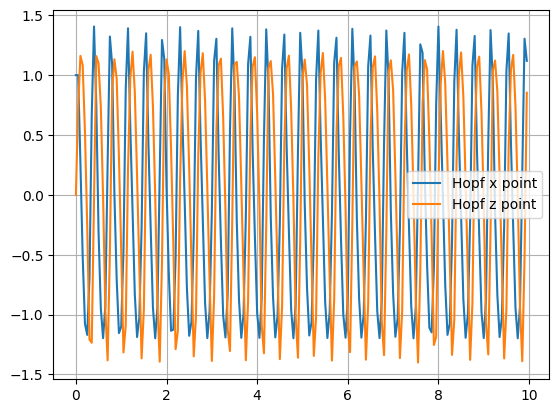

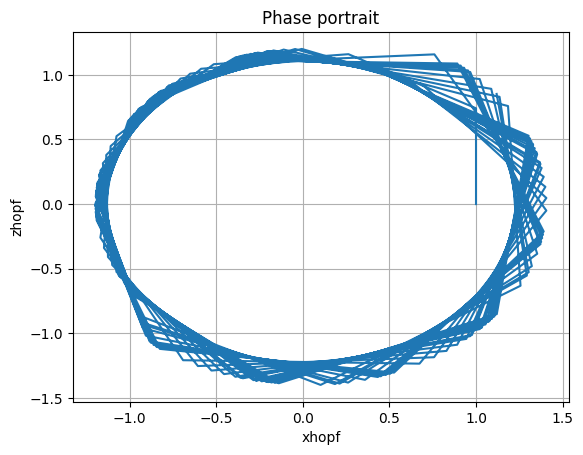

In [162]:
### Hopf Oscillator for central pattern generator based off the work of Zeng et al.

def HopfOscillator(x,z,alpha,gamma,mu,dutycycle,T,b,dt):
    stance_denom=dutycycle*T*(np.exp(-b*z)+1)
    swing_denom=(1-dutycycle)*T*(np.exp(b*z)+1)
    omega=np.pi/stance_denom+np.pi/swing_denom
    rsquared=x**2+z**2
    dxdt=alpha*(mu-rsquared)*x-omega*z
    dzdt=gamma*(mu-rsquared)*z+omega*x
    x_new=x+dxdt*dt
    z_new=z+dzdt*dt

    return x_new,z_new

dT=0.05
tt=10
steps=int(tt/dT)
xx=1
zz=0
x_pos=[]
z_pos=[]
ts=[]

for i in range(steps):
    x_pos.append(xx)
    z_pos.append(zz)
    ts.append(i*dT)
    xx,zz=HopfOscillator(xx,zz,alpha=10,gamma=10,mu=1,dutycycle=0.58,T=1/2.3,b=50,dt=dT)
    
    

plt.plot(ts,x_pos, label='Hopf x point')
plt.plot(ts,z_pos, label='Hopf z point')
plt.legend()
plt.grid()
plt.show()


plt.plot(x_pos,z_pos, label='Hopf phase protrait')
plt.xlabel('xhopf')
plt.ylabel('zhopf')
plt.grid()
plt.title('Phase portrait')
plt.show()
## we know that walk is a saw tooth and trot is a sine wave or general assumption of a sine wave is useful to estimate the gait of the bittle for simplicity

## use Hopf oscillator for phase tracking

def TrajectoryGeneratorSine(x_hopf,z_hopf,S,H,dutycycle):
    XX=[]
    ZZ=[]
    
    for i in range(len(x_hopf)):
        phase_rad=np.arctan2(z_hopf[i],x_hopf[i])
        phase_norm=(phase_rad+np.pi)/(2*np.pi)
        x=S/2*np.cos(2*np.pi*phase_norm)

        shifted_phase_norm=(phase_norm+0.5) %1 ## renormalize the phase norm since the original phase normalized has a half a cycle worth of discrepancy
        if shifted_phase_norm < (1-dutycycle):
            z = H * np.sin(2 * np.pi * shifted_phase_norm)
            
        else:
            z = 0  # stance phase
        XX.append(x)
        ZZ.append(z)
        

    return XX,ZZ



# X,Z,T=TrajectoryGeneratorSine(x_pos,z_pos,S=70.1,H=4.39,dt=0.05,dutycycle=0.5815)
# plt.plot(T,X)
# plt.plot(T,Z)
# plt.show()


## incorporation of the phase differences between walking and the trot gaits built in
## using Inverse Kinematics to find the joint angles (2DoF) to be fed into the simulator (potential idea: do it from the orgin of the robot)



[-0.99968419  0.0251301   1.          0.          1.          0.
 -0.99968419  0.0251301 ]


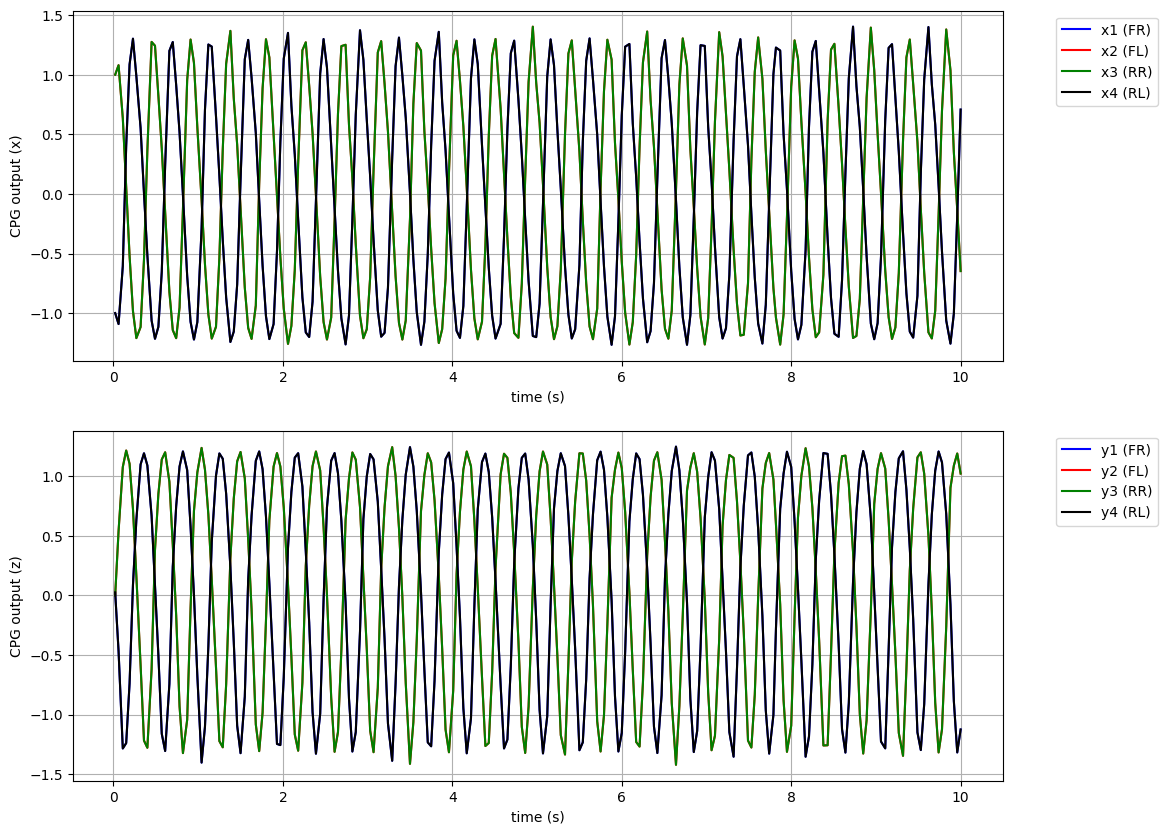

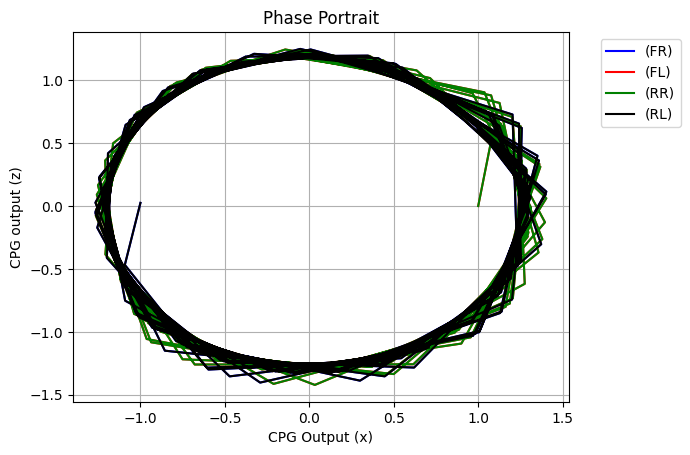

In [163]:
## phase difference taken into account

trot_phase_difference=np.array([0.496,0,0,0.496])*np.pi*2 #phase as a fraction of cycles is converted to radians for calculations
walk_phase_difference=np.array([0,0.5,0.15,0.35])*np.pi*2 # values are rounded to match the standard walkking patterns, can be replaced directly with numbers from data as necessary 

def connectionwieghtmatrixR(phase_difference):
    R=np.zeros((8,8)) # is=ts 4x4 matrix with each block being 2x2 so the total dimensions end up being 8x8
    for j in range(4): #rows
        for i in range(4): #columns
            qji=phase_difference[i]-phase_difference[j]
            Rji=np.array([[np.cos(qji),-np.sin(qji)],[np.sin(qji),np.cos(qji)]])
            R[2*j:2*j+2,2*i:2*i+2]=Rji

    R=np.round(R,decimals=2)
    return R

R_trot=connectionwieghtmatrixR(trot_phase_difference) # connection matrix for trot
R_walk=connectionwieghtmatrixR(walk_phase_difference) #connection matrix for walking

def hopf_cpg_dot(Q,R,delta,dutycycle,T,b,mu,alpha,gamma,dt):
    q_dot=np.zeros(8) #Q=[x1,y1,x2,y2,x3,y3,x4,y4]

    for i in range(4):
        xi=Q[2*i]
        zi=Q[2*i+1]
        q=np.array([[xi],[zi]])
        r2=xi**2+zi**2
        stance_denom=dutycycle*T*(np.exp(-b*zi)+1)
        swing_denom=(1-dutycycle)*T*(np.exp(b*zi)+1)
        omega=np.pi/stance_denom+np.pi/swing_denom
        A=np.array([[alpha*(mu-r2),-omega],[omega,gamma*(mu-r2)]])
        q_dot_first_term=A@q  # covers the first term in equation (9) from Zeng et. al
        q_dot[2*i:2*i+2]=q_dot_first_term.flatten()
    
    # second term
    q_dot += delta * R @ Q  
    Q_new=Q+q_dot*dt
    return Q_new


# dt=0.05
# timetotal=10
steps=len(time)

Q=np.zeros(8)

## define Q with the inital phase differences for the desired gait pattern
for i in range(4):
    Q[2*i]=np.cos(trot_phase_difference[i])
    Q[2*i+1]=np.sin(trot_phase_difference[i])

print(Q)

Q_data=[]
dTT=time[1]-time[0]

for i in range(steps):
    Q_data.append(Q)
    if i<steps-1:
        dTT=time[i+1]-time[i]
        Q=hopf_cpg_dot(Q,alpha=10,gamma=10,mu=1,dutycycle=0.5815,T=1/2.1,b=50,dt=dTT,R=R_trot,delta=0.5)
    
  

Q_data=np.array(Q_data)
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(time[:],Q_data[:,0],color='b',label='x1 (FR)')
plt.plot(time[:],Q_data[:,2],color='r',label='x2 (FL)')
plt.plot(time[:],Q_data[:,4],color='g', label='x3 (RR)')
plt.plot(time[:],Q_data[:,6],color='k',label='x4 (RL)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xlabel('time (s)')
plt.ylabel('CPG output (x)')


plt.subplot(2,1,2)
plt.plot(time[:],Q_data[:,1],color='b',label='y1 (FR)')
plt.plot(time[:],Q_data[:,3],color='r',label='y2 (FL)')
plt.plot(time[:],Q_data[:,5],color='g', label='y3 (RR)')
plt.plot(time[:],Q_data[:,7],color='k',label='y4 (RL)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xlabel('time (s)')
plt.ylabel('CPG output (z)')
plt.show()

plt.plot(Q_data[:,0],Q_data[:,1],color='b',label='(FR)')
plt.plot(Q_data[:,2],Q_data[:,3],color='r',label='(FL)')
plt.plot(Q_data[:,4],Q_data[:,5],color='g', label='(RR)')
plt.plot(Q_data[:,6],Q_data[:,7],color='k',label='(RL)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xlabel('CPG Output (x)')
plt.ylabel('CPG output (z)')
plt.title('Phase Portrait')
plt.show()


X1,Z1=TrajectoryGeneratorSine(x_hopf=Q_data[:,0],z_hopf=Q_data[:,1],S=70.1,H=4.39,dutycycle=0.5815)
X2,Z2=TrajectoryGeneratorSine(x_hopf=Q_data[:,2],z_hopf=Q_data[:,3],S=70.1,H=4.39,dutycycle=0.5815)
X3,Z3=TrajectoryGeneratorSine(x_hopf=Q_data[:,4],z_hopf=Q_data[:,5],S=70.1,H=4.39,dutycycle=0.5815)
X4,Z4=TrajectoryGeneratorSine(x_hopf=Q_data[:,6],z_hopf=Q_data[:,7],S=70.1,H=4.39,dutycycle=0.5815)






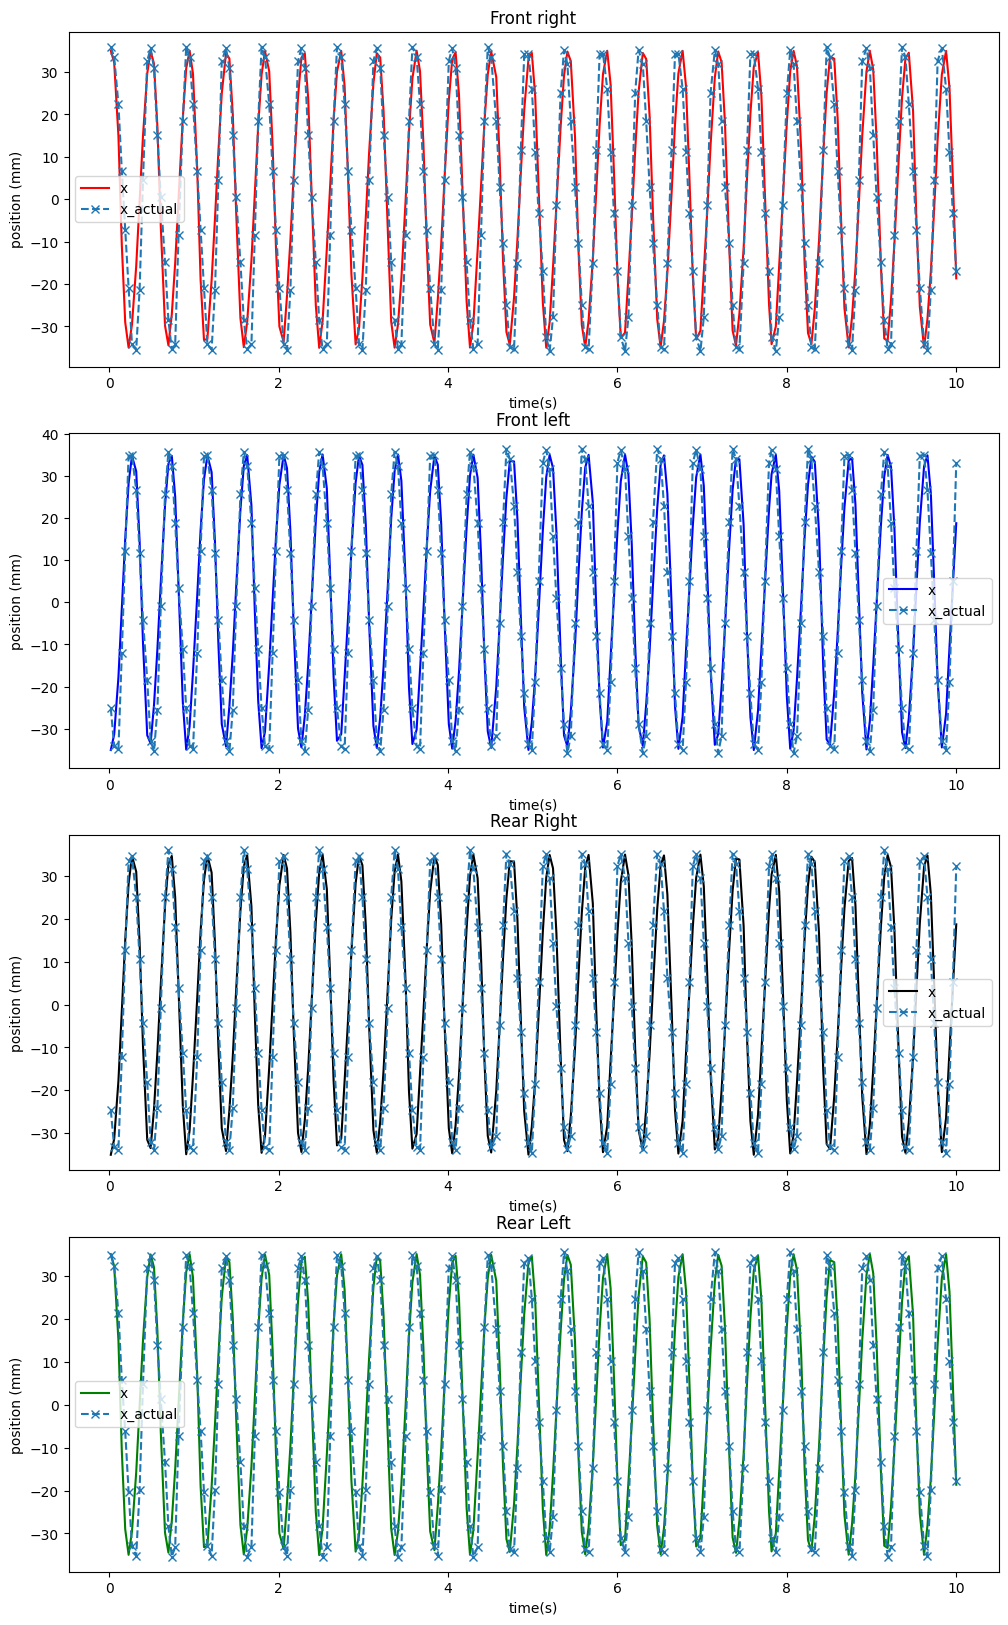

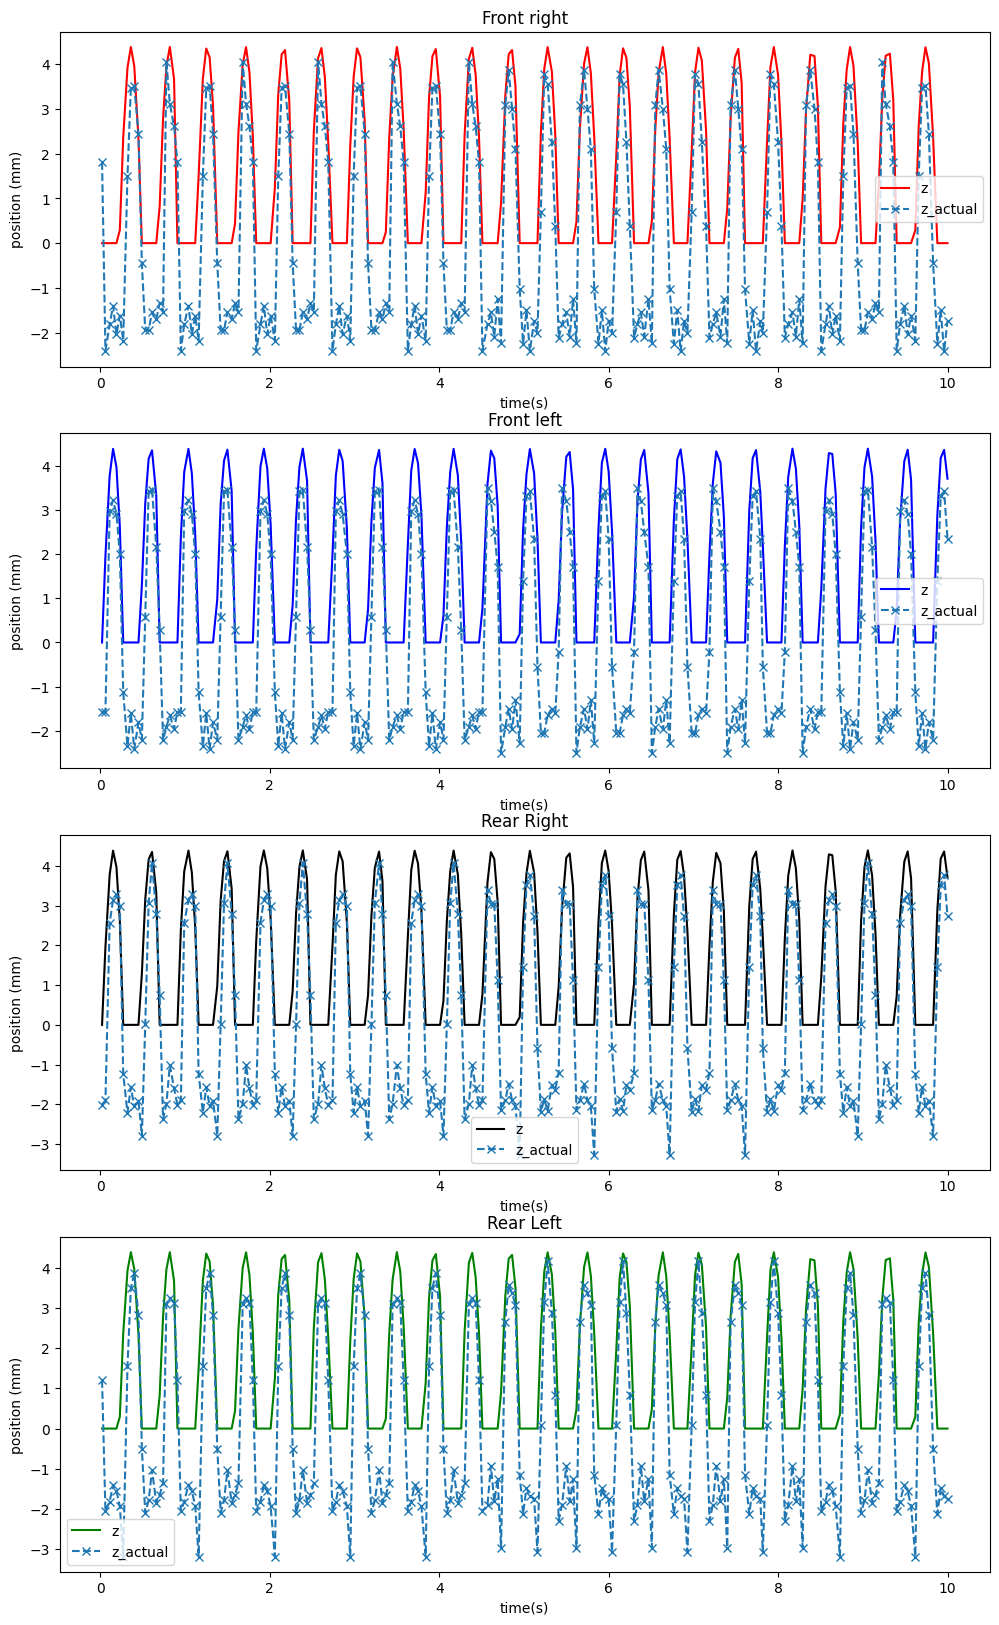

In [ ]:
#plotting the x generated by the CPG and the actual model, after removing the DC offset (x-offset)

plt.figure(figsize=(12,20))
plt.subplot(4,1,1)
plt.plot(time[:],X1, color='r', label='x')
# plt.plot(T1,Z1,label='z')
plt.plot(time,footpos_mm[0,:,0]-np.mean(footpos_mm[0,:,0]),label='x_actual',marker='x',ls='--')
plt.title('Front right')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()


plt.subplot(4,1,2)
plt.plot(time[:],X2, color='b', label='x')
# plt.plot(T1,Z2,label='z')
plt.plot(time,footpos_mm[1,:,0]-np.mean(footpos_mm[1,:,0]), label='x_actual',marker='x',ls='--')
plt.title('Front left')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()

plt.subplot(4,1,3)
plt.plot(time[:],X3, color='k',label='x')
# plt.plot(T1,Z3,label='z')
plt.plot(time,footpos_mm[2,:,0]-np.mean(footpos_mm[2,:,0]), label='x_actual',marker='x',ls='--')
plt.title('Rear Right')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()

plt.subplot(4,1,4)
plt.plot(time[:],X4, color='g',label='x')
# plt.plot(T1,Z4,label='z')
plt.plot(time,footpos_mm[3,:,0]-np.mean(footpos_mm[3,:,0]),label='x_actual',marker='x',ls='--')
plt.title('Rear Left')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()
plt.show()



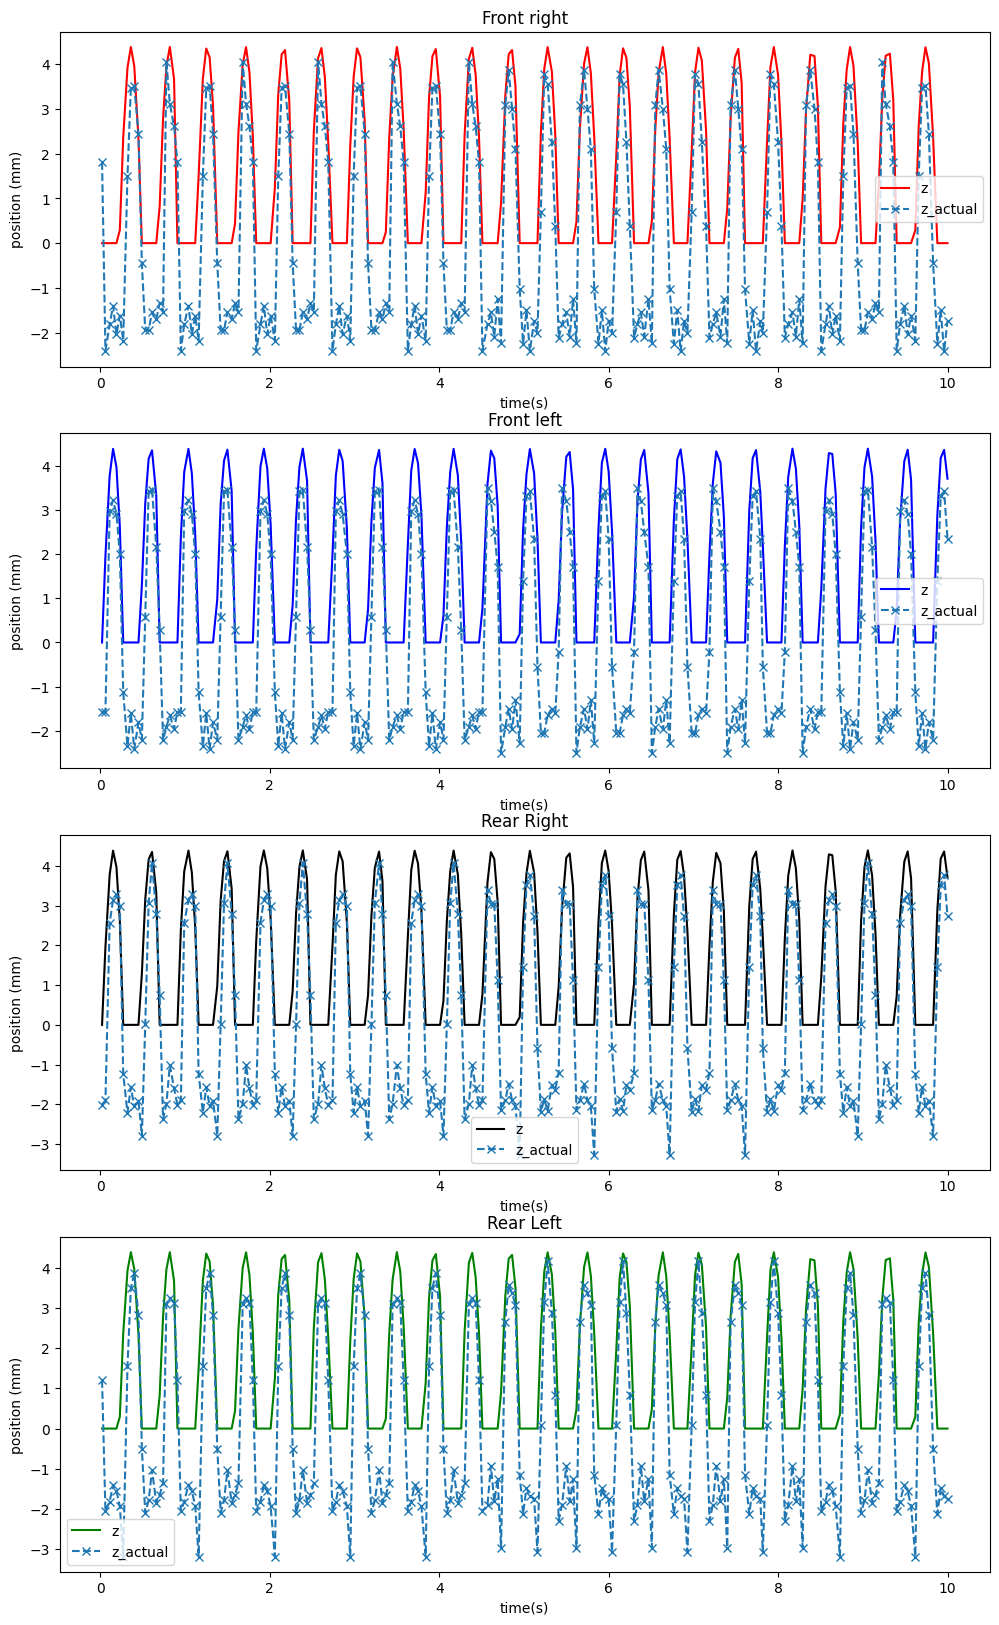

In [165]:
## plotting the z data by the CPG and the actual model, after removing the DC offset (x-offset)



plt.figure(figsize=(12,20))
plt.subplot(4,1,1)
plt.plot(time[:],Z1, color='r', label='z')
# plt.plot(T1,Z1,label='z')
plt.plot(time,footpos_mm[0,:,2]-np.mean(footpos_mm[0,:,2]),label='z_actual',marker='x',ls='--')
plt.title('Front right')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()


plt.subplot(4,1,2)
plt.plot(time[:],Z2, color='b', label='z')
# plt.plot(T1,Z2,label='z')
plt.plot(time,footpos_mm[1,:,2]-np.mean(footpos_mm[1,:,2]), label='z_actual',marker='x',ls='--')
plt.title('Front left')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()

plt.subplot(4,1,3)
plt.plot(time[:],Z3, color='k',label='z')
# plt.plot(T1,Z3,label='z')
plt.plot(time,footpos_mm[2,:,2]-np.mean(footpos_mm[2,:,2]), label='z_actual',marker='x',ls='--')
plt.title('Rear Right')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()

plt.subplot(4,1,4)
plt.plot(time[:],Z4, color='g',label='z')
# plt.plot(T1,Z4,label='z')
plt.plot(time,footpos_mm[3,:,2]-np.mean(footpos_mm[3,:,2]),label='z_actual',marker='x',ls='--')
plt.title('Rear Left')
plt.xlabel('time(s)')
plt.ylabel('position (mm)')
plt.legend()

plt.show()
